***Notice: In all code in this jupyter, all y_labels are not np.array. Do y_labels = np.asarray(y_labels) if need***

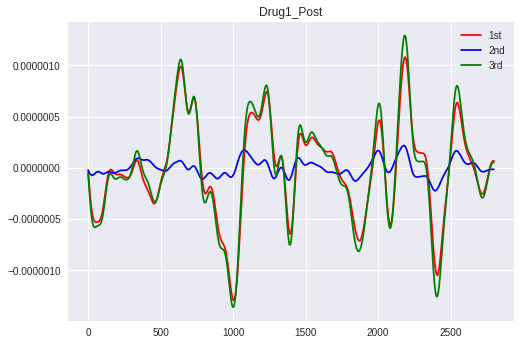

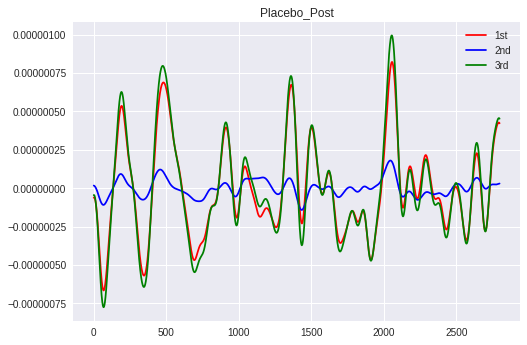

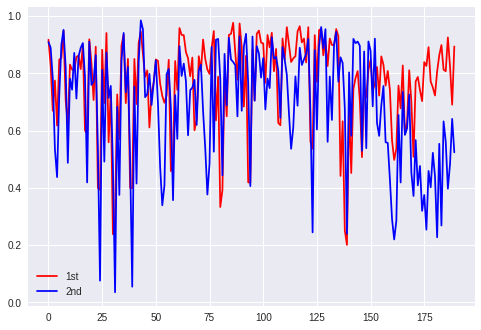

In [0]:
# -*- coding: utf-8 -*-
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random
import math

import sklearn
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


# ==== ==== ==== ==== Load and cut 2800 ==== ==== ==== ==== 
#dataDrug1 = sio.loadmat('drug1.mat')        # 28 
#dataPlacebo = sio.loadmat('placebo.mat')    #33
dataDrug1_2 = sio.loadmat('drug1_2.mat')    #48

dataDrug1 = sio.loadmat('drug_post1.mat')        # 28 
dataPlacebo = sio.loadmat('placebo_post.mat')    #33

#listDrug1ReadDict = dataDrug1['drug1']
#listPlaceboReadDict = dataPlacebo['placebo']
listDrug1ReadDict = dataDrug1['drug_post1']
listPlaceboReadDict = dataPlacebo['placebo_post']
listDrug1_2ReadDict = dataDrug1_2['drug1_2']


listDrug1ReadDict = listDrug1ReadDict.transpose()
listPlaceboReadDict = listPlaceboReadDict.transpose()
listDrug1_2ReadDict = listDrug1_2ReadDict.transpose()




def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2800, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)
listDrug1_2 = cut_to_2800(listDrug1_2ReadDict)

# ==== ==== ==== ==== Focus on 1st and 2nd for drug and placebo ==== ==== ==== ==== 
def extract_One_Two(list):
    temp1 = []
    temp2 = []
    for i in range(list.shape[0]):
        temp1.append(list[i][:, 0, :])
        temp2.append(list[i][:, 1, :])
    temp1 = np.array(temp1)
    temp2 = np.array(temp2)
    return (temp1, temp2)

[listDrug1_1st, listDrug1_2nd]  = extract_One_Two(listDrug1)
[listPlacebo_1st, listPlacebo_2nd]  = extract_One_Two(listPlacebo)
[listDrug1_2_1st, listDrug1_2_2nd]  = extract_One_Two(listDrug1_2)


# ==== ==== ==== ==== P coeff & vetorized ==== ==== ==== ==== 
def correlation_compute(list):
    vetor = []
    corr_matrix = []
    #print(list.shape[0])
    for ID in range(list.shape[0]):
        tempCorrMatrix = np.identity(20)
        tempVector = []
        for i in range(20):
            count = 0
            for j in range(20):
                if i == j:
                    continue
                temp = np.corrcoef(list[ID][:,i],  list[ID][:,j])
                tempCorrMatrix[i][j] = temp[0][1]
                if count < i:
                    tempVector.append(temp[0][1])
                    count += 1
        vetor.append(tempVector)
        corr_matrix.append(tempCorrMatrix)
    vetor = np.array(vetor)
    corr_matrix = np.array(corr_matrix)
    return (vetor, corr_matrix)

def correlation_compute_2D_input(list):
    vetor = []
    corr_matrix = []
    #print(list.shape[0])
    tempCorrMatrix = np.identity(20)
    tempVector = []
    for i in range(20):
        count = 0
        for j in range(20):
            if i == j:
                continue
            temp = np.corrcoef(list[:,i],  list[:,j])
            tempCorrMatrix[i][j] = temp[0][1]
            if count < i:
                tempVector.append(temp[0][1])
                count += 1
    vetor.append(tempVector)
    corr_matrix.append(tempCorrMatrix)
    vetor = np.array(vetor)
    corr_matrix = np.array(corr_matrix)
    return (vetor, corr_matrix)

[Drug1_1st_Corr_Vetorized, listDrug1_1st_Corr] = correlation_compute(listDrug1_1st)
[Drug1_2nd_Corr_Vetorized, listDrug1_2nd_Corr] = correlation_compute(listDrug1_2nd)
[Placebo_1st_Corr_Vetorized, listPlacebo_1st_Corr] = correlation_compute(listPlacebo_1st)
[Placebo_2nd_Corr_Vetorized, listPlacebo_2nd_Corr] = correlation_compute(listPlacebo_2nd)
[Drug1_2_1st_Corr_Vetorized, listDrug1_2_1st_Corr] = correlation_compute(listDrug1_2_1st)
[Drug1_2_2nd_Corr_Vetorized, listDrug1_2_2nd_Corr] = correlation_compute(listDrug1_2_2nd)

# ==== ==== ==== ==== Plot ==== ==== ==== ==== 
x = []
for i in range(2800):
    x.append(i)
# Drug
dg = listDrug1[0][:,:, 0]
a1 = dg[:, 0]
a2 = dg[:, 1]
a3 = dg[:, 2]
plt.plot(x, a1, color = 'red', label = '1st')
plt.plot(x, a2,color = 'blue', label = '2nd')
plt.plot(x, a3, color = 'green', label = '3rd')
plt.title('Drug1_Post')
plt.legend()
plt.show()
# Placebo
pl = listPlacebo[0][:,:, 0]
b1 = pl[:, 0]
b2 = pl[:, 1]
b3 = pl[:, 2]
plt.plot(x, b1, color = 'red', label = '1st')
plt.plot(x, b2,color = 'blue', label = '2nd')
plt.plot(x, b3, color = 'green', label = '3rd')
plt.title('Placebo_Post')
plt.legend()
plt.show()



x = []
for kk in range(190):
    x.append(kk)
plt.plot(x, Drug1_1st_Corr_Vetorized[0], color = 'red', label = '1st')
plt.plot(x, Placebo_1st_Corr_Vetorized[0],color = 'blue', label = '2nd')
plt.legend()
plt.show()

# =============================== Functions for following ==============================
def split_to_validation_test(list1, list0): #list1: X with 1, list0: X with 0
    valid = []
    test = []
    valid_label = []
    test_label = []
    
    valid_1 = 0.1
    valid_0 = 0.1
    test_1 = 0.1
    test_0 = 0.1
    
    dict_1 = {}
    upperbound_1 = 0
    while upperbound_1 < math.ceil(valid_1 * len(list1)):
        cur = random.randint(0, len(list1) - 1)
        if cur not in dict_1:
            valid.append(list1[cur])
            valid_label.append(1)
            dict_1[cur] = 'valid'
            upperbound_1 += 1
            
    upperbound_1 = 0
    while upperbound_1 < math.ceil(test_1 * len(list1)):
        cur = random.randint(0, len(list1) - 1)
        if cur not in dict_1:
            test.append(list1[cur])
            test_label.append(1)
            dict_1[cur] = 'test'
            upperbound_1 += 1
            
            
    dict_0 = {}
    upperbound_0 = 0
    while upperbound_0 < math.ceil(valid_0 * len(list0)):
        cur = random.randint(0, len(list0) - 1)
        if cur not in dict_0:
            valid.append(list0[cur])
            valid_label.append(0)
            dict_0[cur] = 'valid'
            upperbound_0 += 1
            
    upperbound_0 = 0
    while upperbound_0 < math.ceil(test_0 * len(list0)):
        cur = random.randint(0, len(list0) - 1)
        if cur not in dict_0:
            test.append(list0[cur])
            test_label.append(0)
            dict_0[cur] = 'test'
            upperbound_0 += 1
            
    # Split traning data from two dict record:
    training = []
    training_label = []
    for x in range(len(list1)):
        if x not in dict_1:
            training.append(list1[x])
            training_label.append(1)

    for x in range(len(list0)):
        if x not in dict_0:
            training.append(list0[x])
            training_label.append(0)
           
    training = np.array(training)    
    training_label = np.array(training_label)   
    valid = np.array(valid)
    test = np.array(test)
    valid_label = np.array(valid_label)
    test_label = np.array(test_label)
     
    return (training, training_label, valid, valid_label, test, test_label)
            
    
    
def stack_by_row(list1, list2):    # For X data
    return np.vstack((list1, list2))

def stack_by_col(list1, list2):    # For y (label data)
    return np.hstack((list1, list2))
    
def permutation(list1, list2):
    if list1.shape[0] != list2.shape[0]:
        print("There is something wrong! In permutation process")
    p = np.random.permutation(list1.shape[0])
    list1 = list1[p, :]
    list2 = list2[p]
    return (list1, list2)

def check_accuracy(trueLabel, pred):
    if len(trueLabel) != len(pred):
        print("Some errors when check accuracy!")
    total = len(pred)
    correct = 0
    for t, p in zip(trueLabel, pred):
        if t == p:
            correct += 1
    return correct / total
      
def fourFolds(X, y):
    if len(X) != len(y):
        print('Sth wrong in fourFolds')
    pos = int(len(X) / 4)
    return (X[:pos], y[: pos], X[pos: 2*pos], y[pos: 2*pos], X[2*pos : 3*pos], y[2*pos : 3*pos], X[3*pos:], y[3*pos:])

def train_predict(clf, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test):
    val_acc = []
    test_acc = []
    clf.fit(stack_by_row(stack_by_row(X1, X2), X3), stack_by_col(stack_by_col(y1, y2), y3))
    res_v = clf.predict(X4)
    res_t = clf.predict(X_test)
    val_acc.append(check_accuracy(y4, res_v))
    test_acc.append(check_accuracy(y_test, res_t))
    
    clf.fit(stack_by_row(stack_by_row(X1, X2), X4), stack_by_col(stack_by_col(y1, y2), y4))
    res_v = clf.predict(X3)
    res_t = clf.predict(X_test)
    val_acc.append(check_accuracy(y3, res_v))
    test_acc.append(check_accuracy(y_test, res_t))
    
    clf.fit(stack_by_row(stack_by_row(X1, X3), X4), stack_by_col(stack_by_col(y1, y3), y4))
    res_v = clf.predict(X2)
    res_t = clf.predict(X_test)
    val_acc.append(check_accuracy(y2, res_v))
    test_acc.append(check_accuracy(y_test, res_t))
    
    clf.fit(stack_by_row(stack_by_row(X2, X3), X4), stack_by_col(stack_by_col(y2, y3), y4))
    res_v = clf.predict(X1)
    res_t = clf.predict(X_test)
    val_acc.append(check_accuracy(y1, res_v))
    test_acc.append(check_accuracy(y_test, res_t))
    return val_acc, test_acc


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


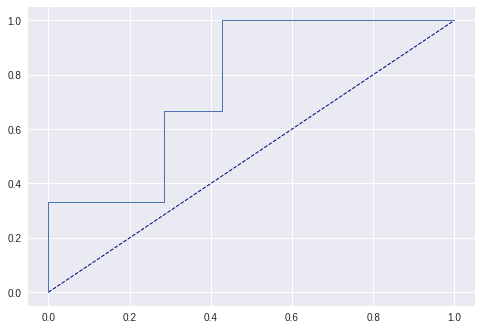

crossvalid: 0.526316, 0.473684, 0.684211, 0.684211
Test acc: 0.500000, 0.500000, 0.500000, 0.800000



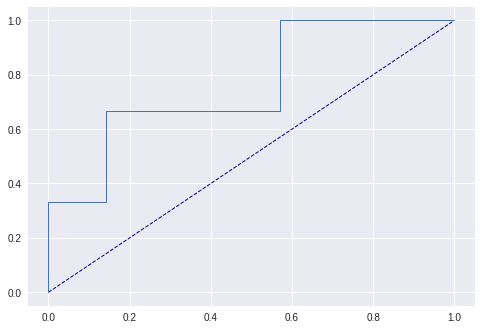

crossvalid: 0.578947, 0.473684, 0.684211, 0.631579
Test acc: 0.700000, 0.600000, 0.600000, 0.700000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

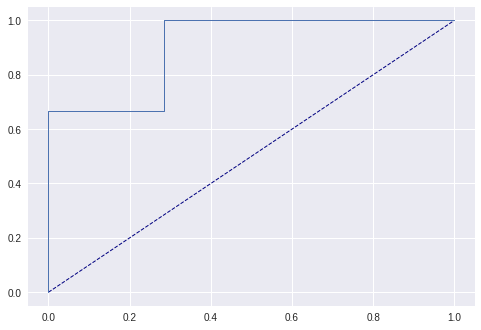

crossvalid: 0.736842, 0.631579, 0.684211, 0.789474
Test acc: 0.700000, 0.700000, 0.700000, 0.700000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

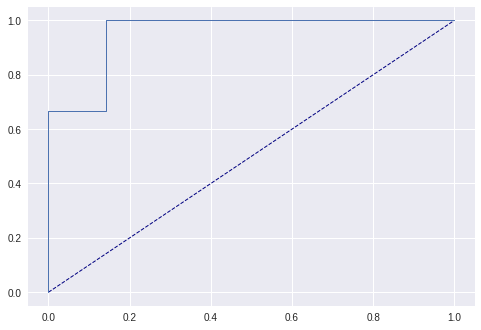

crossvalid: 0.578947, 0.473684, 0.578947, 0.526316
Test acc: 0.700000, 0.700000, 0.700000, 0.800000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


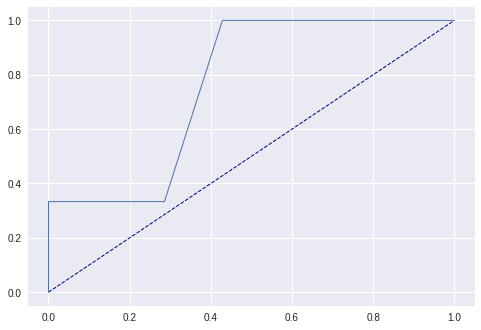

crossvalid: 0.736842, 0.368421, 0.631579, 0.578947
Test acc: 0.700000, 0.700000, 0.800000, 0.800000



In [0]:
# ==== ==== ==== ==== Training by Drug1 and Placebo 1st ==== ==== ==== ==== 

# ==== ==== ==== ==== ==== ==== ==== ====    
# 4 CrossValid, 60% traning, 20% valid, 20% test.
X, y, X_v, y_v, X_test, y_test = split_to_validation_test(Drug1_1st_Corr_Vetorized, Placebo_1st_Corr_Vetorized)
X_temp = stack_by_row(X, X_v)
y_temp = stack_by_col(y, y_v)
X_temp, y_temp = permutation(X_temp, y_temp)
X1, y1, X2, y2, X3, y3, X4, y4 = fourFolds(X_temp, y_temp)

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


## 50 * 500

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


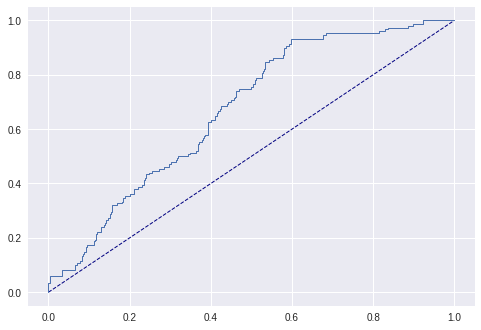

crossvalid: 0.531579, 0.640000, 0.713684, 0.524211
Test acc: 0.578000, 0.662000, 0.548000, 0.574000



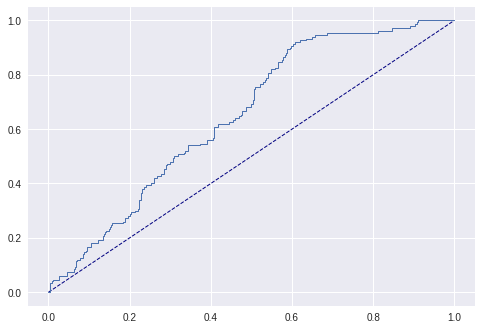

crossvalid: 0.530526, 0.628421, 0.721053, 0.529474
Test acc: 0.588000, 0.662000, 0.548000, 0.562000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

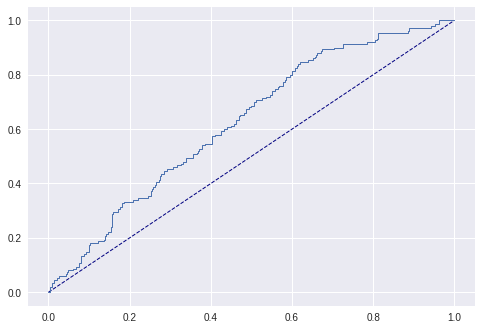

crossvalid: 0.584211, 0.694737, 0.681053, 0.526316
Test acc: 0.674000, 0.666000, 0.616000, 0.568000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


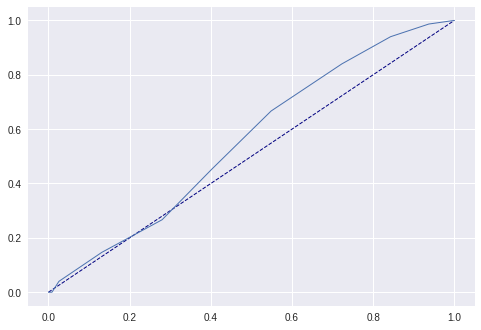

crossvalid: 0.643158, 0.674737, 0.733684, 0.583158
Test acc: 0.684000, 0.654000, 0.666000, 0.584000



In [0]:
def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)

def split_on_subject_level(list_drug, list_placebo):
    test_rate = 0.1
    dict_drug = {}
    dict_place = {}
    
    pre_aug_list_test = []
    pre_aug_label_test = []
    
    pre_aug_list_train = []
    pre_aug_label_train = []
    
    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_drug)):
        cur = random.randint(0, len(list_drug) - 1)
        if cur not in dict_drug:
            pre_aug_list_test.append(list_drug[cur])
            pre_aug_label_test.append(1)
            dict_drug[cur] = 'test'
            upperbound += 1

    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_placebo)):
        cur = random.randint(0, len(list_placebo) - 1)
        if cur not in dict_place:
            pre_aug_list_test.append(list_placebo[cur])
            pre_aug_label_test.append(0)
            dict_place[cur] = 'test'
            upperbound += 1

    for x in range(len(list_drug)):
        if x not in dict_drug:
            pre_aug_list_train.append(list_drug[x])
            pre_aug_label_train.append(1)
            
    for x in range(len(list_placebo)):
        if x not in dict_place:
            pre_aug_list_train.append(list_placebo[x])
            pre_aug_label_train.append(0)
    
    temp1 = []
    #temp2 = []
    for i in range(len(pre_aug_list_test)):
        temp1.append(pre_aug_list_test[i][:, 0, :])
        #temp2.append(pre_aug_label_test[i][:, 1, :])
        
    temp3 = []
    #temp4 = []
    for i in range(len(pre_aug_list_train)):
        temp3.append(pre_aug_list_train[i][:, 0, :])
        #temp4.append(pre_aug_label_train[i][:, 1, :])

    pre_aug_list_test = np.array(temp1)
    pre_aug_label_test = np.array(pre_aug_label_test)
    
    pre_aug_list_train = np.array(temp3)
    pre_aug_label_train = np.array(pre_aug_label_train)
    #print(pre_aug_list_train.shape)
    #print(pre_aug_label_train.shape)
    #print(pre_aug_list_test.shape)
    #print(pre_aug_label_test.shape)
    return (pre_aug_list_train, pre_aug_label_train, pre_aug_list_test, pre_aug_label_test)

[p_Xtemp, p_ytemp, p_X_test, p_y_test] = split_on_subject_level(listDrug1, listPlacebo)
######## permutation ########
if (p_Xtemp.shape[0] != p_ytemp.shape[0]):
    print("DAMN!")
permutation = np.random.permutation(p_Xtemp.shape[0])
p_Xtemp = p_Xtemp[permutation, :]
p_ytemp = p_ytemp[permutation]
######## permutation ########
def split_individual_before_aug(X, y):
    div = int(len(X) / 4)
    if len(X) != len(y):
        print('Sth wrong!!!!!!!')
    p_X1 = p_Xtemp[0 : div]
    p_y1 = p_ytemp[0 : div]
    p_X2 = p_Xtemp[div : 2 * div]
    p_y2 = p_ytemp[div : 2 * div]
    p_X3 = p_Xtemp[2 * div : 3 * div]
    p_y3 = p_ytemp[2 * div : 3 * div]
    p_X4 = p_Xtemp[3 * div :]
    p_y4 = p_ytemp[3 * div :]
    return (p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4)

p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4 = split_individual_before_aug(p_Xtemp, p_ytemp)


def aug_data(list, label, num_windows, len_windows):
    aug_list = []
    aug_label = []
    #print(list.shape[0])
    for i in range(list.shape[0]): # number of subjects
        for j in range(num_windows):
            randNum = np.random.randint(0,2700 - len_windows)
            #print(list[i].shape)
            temp = list[i][randNum : randNum + len_windows, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            #print(vec.tolist())
            aug_list.append(vec.tolist())
            aug_label.append(label[i])
        #if len(aug_label) % 100 == 0:
            #print(len(aug_label))
    aug_list = np.array(aug_list)        
    aug_label = np.array(aug_label)
    return (aug_list, aug_label)

X1, y1 = aug_data(p_X1, p_y1, 50, 500)
X2, y2 = aug_data(p_X2, p_y2, 50, 500)
X3, y3 = aug_data(p_X3, p_y3, 50, 500)
X4, y4 = aug_data(p_X4, p_y4, 50, 500)
X_test, y_test = aug_data(p_X_test, p_y_test, 50, 500)

X1 = np.squeeze(X1, axis=(1,))
X2 = np.squeeze(X2, axis=(1,))
X3 = np.squeeze(X3, axis=(1,))
X4 = np.squeeze(X4, axis=(1,))
X_test = np.squeeze(X_test, axis=(1,))

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
'''
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
'''

# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


## 50 X 1000

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


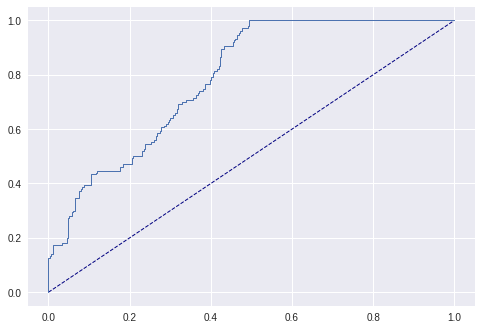

crossvalid: 0.558947, 0.510526, 0.574737, 0.625263
Test acc: 0.722000, 0.858000, 0.788000, 0.678000



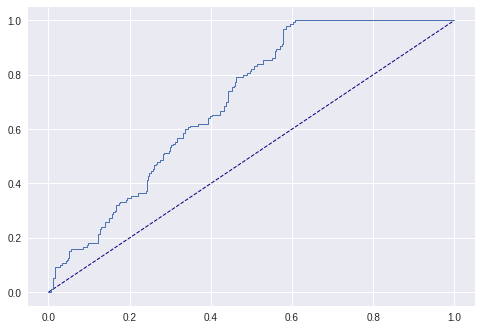

crossvalid: 0.560000, 0.482105, 0.613684, 0.672632
Test acc: 0.758000, 0.798000, 0.754000, 0.654000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

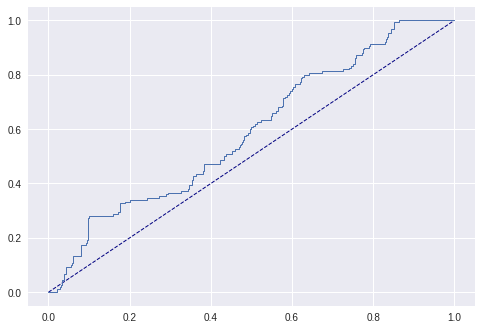

crossvalid: 0.529474, 0.517895, 0.645263, 0.647368
Test acc: 0.638000, 0.728000, 0.754000, 0.574000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


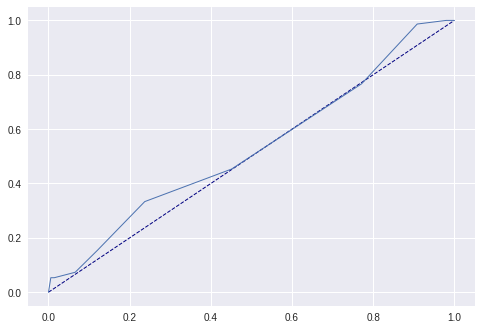

crossvalid: 0.629474, 0.710526, 0.717895, 0.638947
Test acc: 0.686000, 0.710000, 0.676000, 0.662000



In [0]:
def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)

def split_on_subject_level(list_drug, list_placebo):
    test_rate = 0.1
    dict_drug = {}
    dict_place = {}
    
    pre_aug_list_test = []
    pre_aug_label_test = []
    
    pre_aug_list_train = []
    pre_aug_label_train = []
    
    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_drug)):
        cur = random.randint(0, len(list_drug) - 1)
        if cur not in dict_drug:
            pre_aug_list_test.append(list_drug[cur])
            pre_aug_label_test.append(1)
            dict_drug[cur] = 'test'
            upperbound += 1

    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_placebo)):
        cur = random.randint(0, len(list_placebo) - 1)
        if cur not in dict_place:
            pre_aug_list_test.append(list_placebo[cur])
            pre_aug_label_test.append(0)
            dict_place[cur] = 'test'
            upperbound += 1

    for x in range(len(list_drug)):
        if x not in dict_drug:
            pre_aug_list_train.append(list_drug[x])
            pre_aug_label_train.append(1)
            
    for x in range(len(list_placebo)):
        if x not in dict_place:
            pre_aug_list_train.append(list_placebo[x])
            pre_aug_label_train.append(0)
    
    temp1 = []
    #temp2 = []
    for i in range(len(pre_aug_list_test)):
        temp1.append(pre_aug_list_test[i][:, 0, :])
        #temp2.append(pre_aug_label_test[i][:, 1, :])
        
    temp3 = []
    #temp4 = []
    for i in range(len(pre_aug_list_train)):
        temp3.append(pre_aug_list_train[i][:, 0, :])
        #temp4.append(pre_aug_label_train[i][:, 1, :])

    pre_aug_list_test = np.array(temp1)
    pre_aug_label_test = np.array(pre_aug_label_test)
    
    pre_aug_list_train = np.array(temp3)
    pre_aug_label_train = np.array(pre_aug_label_train)
    #print(pre_aug_list_train.shape)
    #print(pre_aug_label_train.shape)
    #print(pre_aug_list_test.shape)
    #print(pre_aug_label_test.shape)
    return (pre_aug_list_train, pre_aug_label_train, pre_aug_list_test, pre_aug_label_test)

[p_Xtemp, p_ytemp, p_X_test, p_y_test] = split_on_subject_level(listDrug1, listPlacebo)
######## permutation ########
if (p_Xtemp.shape[0] != p_ytemp.shape[0]):
    print("DAMN!")
permutation = np.random.permutation(p_Xtemp.shape[0])
p_Xtemp = p_Xtemp[permutation, :]
p_ytemp = p_ytemp[permutation]
######## permutation ########
def split_individual_before_aug(X, y):
    div = int(len(X) / 4)
    if len(X) != len(y):
        print('Sth wrong!!!!!!!')
    p_X1 = p_Xtemp[0 : div]
    p_y1 = p_ytemp[0 : div]
    p_X2 = p_Xtemp[div : 2 * div]
    p_y2 = p_ytemp[div : 2 * div]
    p_X3 = p_Xtemp[2 * div : 3 * div]
    p_y3 = p_ytemp[2 * div : 3 * div]
    p_X4 = p_Xtemp[3 * div :]
    p_y4 = p_ytemp[3 * div :]
    return (p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4)

p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4 = split_individual_before_aug(p_Xtemp, p_ytemp)


def aug_data(list, label, num_windows, len_windows):
    aug_list = []
    aug_label = []
    #print(list.shape[0])
    for i in range(list.shape[0]): # number of subjects
        for j in range(num_windows):
            randNum = np.random.randint(0,2700 - len_windows)
            #print(list[i].shape)
            temp = list[i][randNum : randNum + len_windows, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            #print(vec.tolist())
            aug_list.append(vec.tolist())
            aug_label.append(label[i])
        #if len(aug_label) % 100 == 0:
            #print(len(aug_label))
    aug_list = np.array(aug_list)        
    aug_label = np.array(aug_label)
    return (aug_list, aug_label)

X1, y1 = aug_data(p_X1, p_y1, 50, 1000)
X2, y2 = aug_data(p_X2, p_y2, 50, 1000)
X3, y3 = aug_data(p_X3, p_y3, 50, 1000)
X4, y4 = aug_data(p_X4, p_y4, 50, 1000)
X_test, y_test = aug_data(p_X_test, p_y_test, 50, 1000)

X1 = np.squeeze(X1, axis=(1,))
X2 = np.squeeze(X2, axis=(1,))
X3 = np.squeeze(X3, axis=(1,))
X4 = np.squeeze(X4, axis=(1,))
X_test = np.squeeze(X_test, axis=(1,))

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
'''
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
'''

# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


## 50 X 1500

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


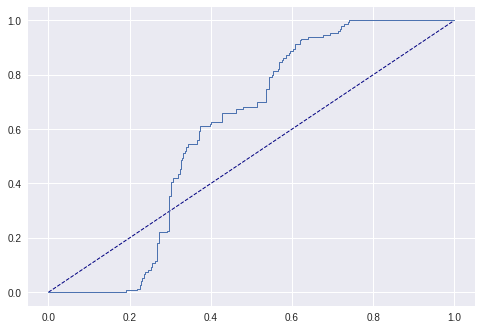

crossvalid: 0.637895, 0.474737, 0.808421, 0.656842
Test acc: 0.452000, 0.682000, 0.546000, 0.594000



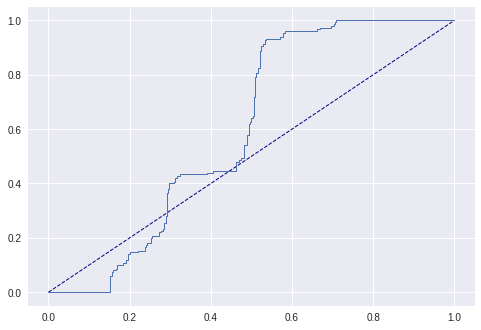

crossvalid: 0.534737, 0.529474, 0.805263, 0.626316
Test acc: 0.498000, 0.524000, 0.500000, 0.606000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

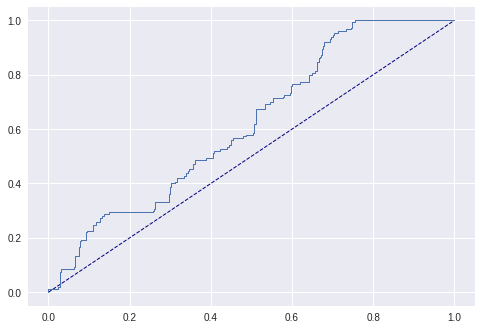

crossvalid: 0.586316, 0.577895, 0.808421, 0.578947
Test acc: 0.590000, 0.678000, 0.526000, 0.596000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


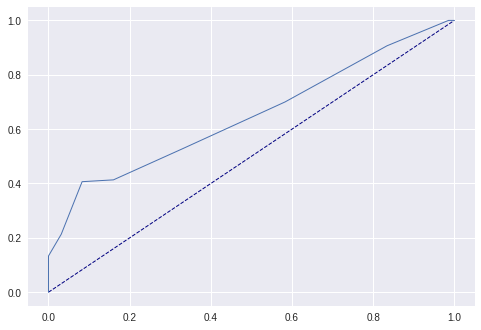

crossvalid: 0.546316, 0.623158, 0.834737, 0.613684
Test acc: 0.612000, 0.666000, 0.552000, 0.764000



In [0]:
def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)

def split_on_subject_level(list_drug, list_placebo):
    test_rate = 0.1
    dict_drug = {}
    dict_place = {}
    
    pre_aug_list_test = []
    pre_aug_label_test = []
    
    pre_aug_list_train = []
    pre_aug_label_train = []
    
    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_drug)):
        cur = random.randint(0, len(list_drug) - 1)
        if cur not in dict_drug:
            pre_aug_list_test.append(list_drug[cur])
            pre_aug_label_test.append(1)
            dict_drug[cur] = 'test'
            upperbound += 1

    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_placebo)):
        cur = random.randint(0, len(list_placebo) - 1)
        if cur not in dict_place:
            pre_aug_list_test.append(list_placebo[cur])
            pre_aug_label_test.append(0)
            dict_place[cur] = 'test'
            upperbound += 1

    for x in range(len(list_drug)):
        if x not in dict_drug:
            pre_aug_list_train.append(list_drug[x])
            pre_aug_label_train.append(1)
            
    for x in range(len(list_placebo)):
        if x not in dict_place:
            pre_aug_list_train.append(list_placebo[x])
            pre_aug_label_train.append(0)
    
    temp1 = []
    #temp2 = []
    for i in range(len(pre_aug_list_test)):
        temp1.append(pre_aug_list_test[i][:, 0, :])
        #temp2.append(pre_aug_label_test[i][:, 1, :])
        
    temp3 = []
    #temp4 = []
    for i in range(len(pre_aug_list_train)):
        temp3.append(pre_aug_list_train[i][:, 0, :])
        #temp4.append(pre_aug_label_train[i][:, 1, :])

    pre_aug_list_test = np.array(temp1)
    pre_aug_label_test = np.array(pre_aug_label_test)
    
    pre_aug_list_train = np.array(temp3)
    pre_aug_label_train = np.array(pre_aug_label_train)
    #print(pre_aug_list_train.shape)
    #print(pre_aug_label_train.shape)
    #print(pre_aug_list_test.shape)
    #print(pre_aug_label_test.shape)
    return (pre_aug_list_train, pre_aug_label_train, pre_aug_list_test, pre_aug_label_test)

[p_Xtemp, p_ytemp, p_X_test, p_y_test] = split_on_subject_level(listDrug1, listPlacebo)
######## permutation ########
if (p_Xtemp.shape[0] != p_ytemp.shape[0]):
    print("DAMN!")
permutation = np.random.permutation(p_Xtemp.shape[0])
p_Xtemp = p_Xtemp[permutation, :]
p_ytemp = p_ytemp[permutation]
######## permutation ########
def split_individual_before_aug(X, y):
    div = int(len(X) / 4)
    if len(X) != len(y):
        print('Sth wrong!!!!!!!')
    p_X1 = p_Xtemp[0 : div]
    p_y1 = p_ytemp[0 : div]
    p_X2 = p_Xtemp[div : 2 * div]
    p_y2 = p_ytemp[div : 2 * div]
    p_X3 = p_Xtemp[2 * div : 3 * div]
    p_y3 = p_ytemp[2 * div : 3 * div]
    p_X4 = p_Xtemp[3 * div :]
    p_y4 = p_ytemp[3 * div :]
    return (p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4)

p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4 = split_individual_before_aug(p_Xtemp, p_ytemp)


def aug_data(list, label, num_windows, len_windows):
    aug_list = []
    aug_label = []
    #print(list.shape[0])
    for i in range(list.shape[0]): # number of subjects
        for j in range(num_windows):
            randNum = np.random.randint(0,2700 - len_windows)
            #print(list[i].shape)
            temp = list[i][randNum : randNum + len_windows, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            #print(vec.tolist())
            aug_list.append(vec.tolist())
            aug_label.append(label[i])
        #if len(aug_label) % 100 == 0:
            #print(len(aug_label))
    aug_list = np.array(aug_list)        
    aug_label = np.array(aug_label)
    return (aug_list, aug_label)

X1, y1 = aug_data(p_X1, p_y1, 50, 1500)
X2, y2 = aug_data(p_X2, p_y2, 50, 1500)
X3, y3 = aug_data(p_X3, p_y3, 50, 1500)
X4, y4 = aug_data(p_X4, p_y4, 50, 1500)
X_test, y_test = aug_data(p_X_test, p_y_test, 50, 1500)

X1 = np.squeeze(X1, axis=(1,))
X2 = np.squeeze(X2, axis=(1,))
X3 = np.squeeze(X3, axis=(1,))
X4 = np.squeeze(X4, axis=(1,))
X_test = np.squeeze(X_test, axis=(1,))

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
'''
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
'''

# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


## 50 X 2000

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


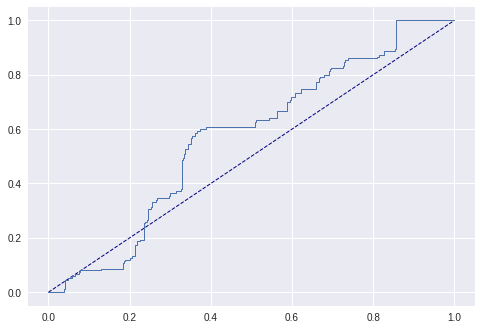

crossvalid: 0.515789, 0.536842, 0.451579, 0.611579
Test acc: 0.540000, 0.738000, 0.542000, 0.614000



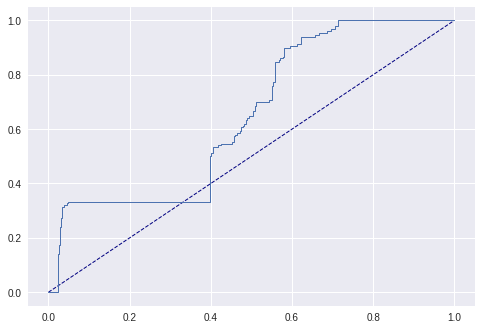

crossvalid: 0.535789, 0.569474, 0.411579, 0.625263
Test acc: 0.616000, 0.700000, 0.538000, 0.540000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

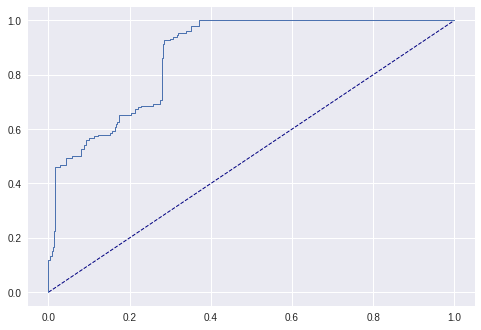

crossvalid: 0.482105, 0.542105, 0.521053, 0.666316
Test acc: 0.638000, 0.920000, 0.774000, 0.740000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


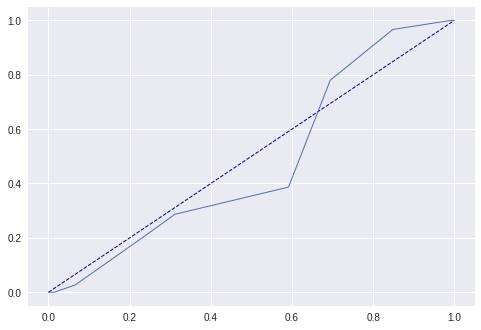

crossvalid: 0.643158, 0.669474, 0.544211, 0.754737
Test acc: 0.568000, 0.712000, 0.696000, 0.596000



In [0]:
def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)

def split_on_subject_level(list_drug, list_placebo):
    test_rate = 0.1
    dict_drug = {}
    dict_place = {}
    
    pre_aug_list_test = []
    pre_aug_label_test = []
    
    pre_aug_list_train = []
    pre_aug_label_train = []
    
    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_drug)):
        cur = random.randint(0, len(list_drug) - 1)
        if cur not in dict_drug:
            pre_aug_list_test.append(list_drug[cur])
            pre_aug_label_test.append(1)
            dict_drug[cur] = 'test'
            upperbound += 1

    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_placebo)):
        cur = random.randint(0, len(list_placebo) - 1)
        if cur not in dict_place:
            pre_aug_list_test.append(list_placebo[cur])
            pre_aug_label_test.append(0)
            dict_place[cur] = 'test'
            upperbound += 1

    for x in range(len(list_drug)):
        if x not in dict_drug:
            pre_aug_list_train.append(list_drug[x])
            pre_aug_label_train.append(1)
            
    for x in range(len(list_placebo)):
        if x not in dict_place:
            pre_aug_list_train.append(list_placebo[x])
            pre_aug_label_train.append(0)
    
    temp1 = []
    #temp2 = []
    for i in range(len(pre_aug_list_test)):
        temp1.append(pre_aug_list_test[i][:, 0, :])
        #temp2.append(pre_aug_label_test[i][:, 1, :])
        
    temp3 = []
    #temp4 = []
    for i in range(len(pre_aug_list_train)):
        temp3.append(pre_aug_list_train[i][:, 0, :])
        #temp4.append(pre_aug_label_train[i][:, 1, :])

    pre_aug_list_test = np.array(temp1)
    pre_aug_label_test = np.array(pre_aug_label_test)
    
    pre_aug_list_train = np.array(temp3)
    pre_aug_label_train = np.array(pre_aug_label_train)
    #print(pre_aug_list_train.shape)
    #print(pre_aug_label_train.shape)
    #print(pre_aug_list_test.shape)
    #print(pre_aug_label_test.shape)
    return (pre_aug_list_train, pre_aug_label_train, pre_aug_list_test, pre_aug_label_test)

[p_Xtemp, p_ytemp, p_X_test, p_y_test] = split_on_subject_level(listDrug1, listPlacebo)
######## permutation ########
if (p_Xtemp.shape[0] != p_ytemp.shape[0]):
    print("DAMN!")
permutation = np.random.permutation(p_Xtemp.shape[0])
p_Xtemp = p_Xtemp[permutation, :]
p_ytemp = p_ytemp[permutation]
######## permutation ########
def split_individual_before_aug(X, y):
    div = int(len(X) / 4)
    if len(X) != len(y):
        print('Sth wrong!!!!!!!')
    p_X1 = p_Xtemp[0 : div]
    p_y1 = p_ytemp[0 : div]
    p_X2 = p_Xtemp[div : 2 * div]
    p_y2 = p_ytemp[div : 2 * div]
    p_X3 = p_Xtemp[2 * div : 3 * div]
    p_y3 = p_ytemp[2 * div : 3 * div]
    p_X4 = p_Xtemp[3 * div :]
    p_y4 = p_ytemp[3 * div :]
    return (p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4)

p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4 = split_individual_before_aug(p_Xtemp, p_ytemp)


def aug_data(list, label, num_windows, len_windows):
    aug_list = []
    aug_label = []
    #print(list.shape[0])
    for i in range(list.shape[0]): # number of subjects
        for j in range(num_windows):
            randNum = np.random.randint(0,2700 - len_windows)
            #print(list[i].shape)
            temp = list[i][randNum : randNum + len_windows, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            #print(vec.tolist())
            aug_list.append(vec.tolist())
            aug_label.append(label[i])
        #if len(aug_label) % 100 == 0:
            #print(len(aug_label))
    aug_list = np.array(aug_list)        
    aug_label = np.array(aug_label)
    return (aug_list, aug_label)

X1, y1 = aug_data(p_X1, p_y1, 50, 2000)
X2, y2 = aug_data(p_X2, p_y2, 50, 2000)
X3, y3 = aug_data(p_X3, p_y3, 50, 2000)
X4, y4 = aug_data(p_X4, p_y4, 50, 2000)
X_test, y_test = aug_data(p_X_test, p_y_test, 50, 2000)

X1 = np.squeeze(X1, axis=(1,))
X2 = np.squeeze(X2, axis=(1,))
X3 = np.squeeze(X3, axis=(1,))
X4 = np.squeeze(X4, axis=(1,))
X_test = np.squeeze(X_test, axis=(1,))

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
'''
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
'''

# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


## 100 X 500

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


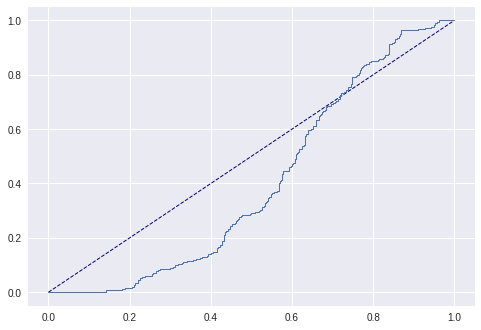

crossvalid: 0.614211, 0.724211, 0.601053, 0.668421
Test acc: 0.667000, 0.592000, 0.550000, 0.530000



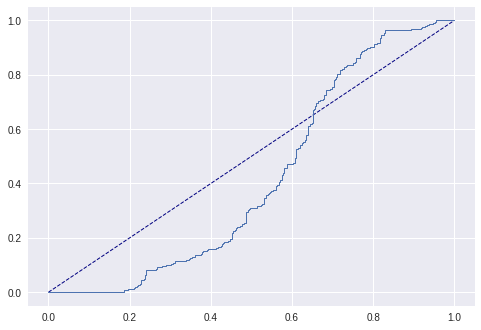

crossvalid: 0.613158, 0.712105, 0.603684, 0.648947
Test acc: 0.652000, 0.594000, 0.562000, 0.536000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

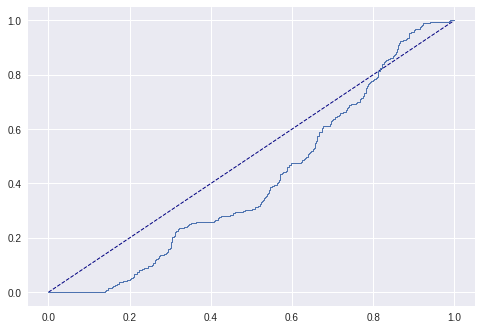

crossvalid: 0.598421, 0.714211, 0.638947, 0.610526
Test acc: 0.704000, 0.625000, 0.650000, 0.557000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


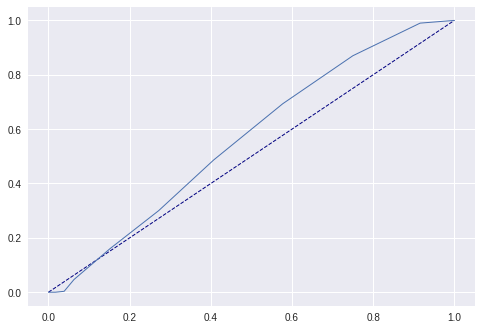

crossvalid: 0.640526, 0.697368, 0.698421, 0.666842
Test acc: 0.657000, 0.660000, 0.678000, 0.642000



In [0]:
def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)

def split_on_subject_level(list_drug, list_placebo):
    test_rate = 0.1
    dict_drug = {}
    dict_place = {}
    
    pre_aug_list_test = []
    pre_aug_label_test = []
    
    pre_aug_list_train = []
    pre_aug_label_train = []
    
    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_drug)):
        cur = random.randint(0, len(list_drug) - 1)
        if cur not in dict_drug:
            pre_aug_list_test.append(list_drug[cur])
            pre_aug_label_test.append(1)
            dict_drug[cur] = 'test'
            upperbound += 1

    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_placebo)):
        cur = random.randint(0, len(list_placebo) - 1)
        if cur not in dict_place:
            pre_aug_list_test.append(list_placebo[cur])
            pre_aug_label_test.append(0)
            dict_place[cur] = 'test'
            upperbound += 1

    for x in range(len(list_drug)):
        if x not in dict_drug:
            pre_aug_list_train.append(list_drug[x])
            pre_aug_label_train.append(1)
            
    for x in range(len(list_placebo)):
        if x not in dict_place:
            pre_aug_list_train.append(list_placebo[x])
            pre_aug_label_train.append(0)
    
    temp1 = []
    #temp2 = []
    for i in range(len(pre_aug_list_test)):
        temp1.append(pre_aug_list_test[i][:, 0, :])
        #temp2.append(pre_aug_label_test[i][:, 1, :])
        
    temp3 = []
    #temp4 = []
    for i in range(len(pre_aug_list_train)):
        temp3.append(pre_aug_list_train[i][:, 0, :])
        #temp4.append(pre_aug_label_train[i][:, 1, :])

    pre_aug_list_test = np.array(temp1)
    pre_aug_label_test = np.array(pre_aug_label_test)
    
    pre_aug_list_train = np.array(temp3)
    pre_aug_label_train = np.array(pre_aug_label_train)
    #print(pre_aug_list_train.shape)
    #print(pre_aug_label_train.shape)
    #print(pre_aug_list_test.shape)
    #print(pre_aug_label_test.shape)
    return (pre_aug_list_train, pre_aug_label_train, pre_aug_list_test, pre_aug_label_test)

[p_Xtemp, p_ytemp, p_X_test, p_y_test] = split_on_subject_level(listDrug1, listPlacebo)
######## permutation ########
if (p_Xtemp.shape[0] != p_ytemp.shape[0]):
    print("DAMN!")
permutation = np.random.permutation(p_Xtemp.shape[0])
p_Xtemp = p_Xtemp[permutation, :]
p_ytemp = p_ytemp[permutation]
######## permutation ########
def split_individual_before_aug(X, y):
    div = int(len(X) / 4)
    if len(X) != len(y):
        print('Sth wrong!!!!!!!')
    p_X1 = p_Xtemp[0 : div]
    p_y1 = p_ytemp[0 : div]
    p_X2 = p_Xtemp[div : 2 * div]
    p_y2 = p_ytemp[div : 2 * div]
    p_X3 = p_Xtemp[2 * div : 3 * div]
    p_y3 = p_ytemp[2 * div : 3 * div]
    p_X4 = p_Xtemp[3 * div :]
    p_y4 = p_ytemp[3 * div :]
    return (p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4)

p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4 = split_individual_before_aug(p_Xtemp, p_ytemp)


def aug_data(list, label, num_windows, len_windows):
    aug_list = []
    aug_label = []
    #print(list.shape[0])
    for i in range(list.shape[0]): # number of subjects
        for j in range(num_windows):
            randNum = np.random.randint(0,2700 - len_windows)
            #print(list[i].shape)
            temp = list[i][randNum : randNum + len_windows, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            #print(vec.tolist())
            aug_list.append(vec.tolist())
            aug_label.append(label[i])
        #if len(aug_label) % 100 == 0:
            #print(len(aug_label))
    aug_list = np.array(aug_list)        
    aug_label = np.array(aug_label)
    return (aug_list, aug_label)

X1, y1 = aug_data(p_X1, p_y1, 100, 500)
X2, y2 = aug_data(p_X2, p_y2, 100, 500)
X3, y3 = aug_data(p_X3, p_y3, 100, 500)
X4, y4 = aug_data(p_X4, p_y4, 100, 500)
X_test, y_test = aug_data(p_X_test, p_y_test, 100, 500)

X1 = np.squeeze(X1, axis=(1,))
X2 = np.squeeze(X2, axis=(1,))
X3 = np.squeeze(X3, axis=(1,))
X4 = np.squeeze(X4, axis=(1,))
X_test = np.squeeze(X_test, axis=(1,))

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
'''
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
'''

# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


## 100 X 1000

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


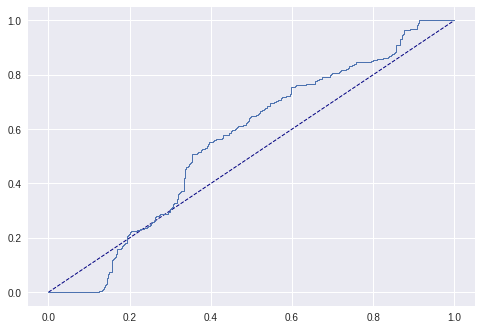

crossvalid: 0.692632, 0.614737, 0.565263, 0.507895
Test acc: 0.853000, 0.720000, 0.600000, 0.599000



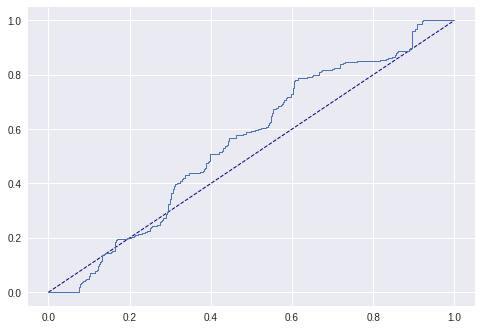

crossvalid: 0.711579, 0.608947, 0.577368, 0.589474
Test acc: 0.785000, 0.734000, 0.630000, 0.598000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

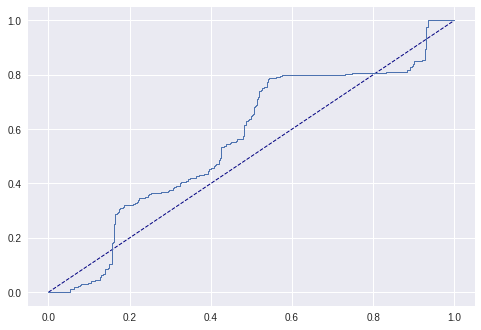

crossvalid: 0.707895, 0.576316, 0.551053, 0.636316
Test acc: 0.709000, 0.729000, 0.664000, 0.659000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


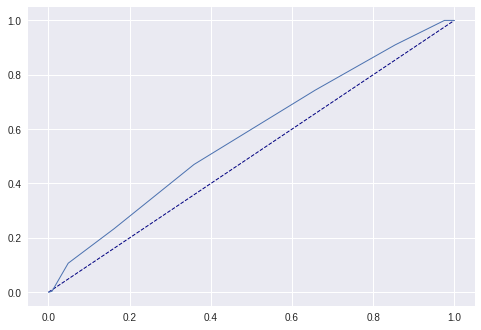

crossvalid: 0.721053, 0.639474, 0.633684, 0.645263
Test acc: 0.688000, 0.652000, 0.738000, 0.698000



In [0]:
def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)

def split_on_subject_level(list_drug, list_placebo):
    test_rate = 0.1
    dict_drug = {}
    dict_place = {}
    
    pre_aug_list_test = []
    pre_aug_label_test = []
    
    pre_aug_list_train = []
    pre_aug_label_train = []
    
    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_drug)):
        cur = random.randint(0, len(list_drug) - 1)
        if cur not in dict_drug:
            pre_aug_list_test.append(list_drug[cur])
            pre_aug_label_test.append(1)
            dict_drug[cur] = 'test'
            upperbound += 1

    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_placebo)):
        cur = random.randint(0, len(list_placebo) - 1)
        if cur not in dict_place:
            pre_aug_list_test.append(list_placebo[cur])
            pre_aug_label_test.append(0)
            dict_place[cur] = 'test'
            upperbound += 1

    for x in range(len(list_drug)):
        if x not in dict_drug:
            pre_aug_list_train.append(list_drug[x])
            pre_aug_label_train.append(1)
            
    for x in range(len(list_placebo)):
        if x not in dict_place:
            pre_aug_list_train.append(list_placebo[x])
            pre_aug_label_train.append(0)
    
    temp1 = []
    #temp2 = []
    for i in range(len(pre_aug_list_test)):
        temp1.append(pre_aug_list_test[i][:, 0, :])
        #temp2.append(pre_aug_label_test[i][:, 1, :])
        
    temp3 = []
    #temp4 = []
    for i in range(len(pre_aug_list_train)):
        temp3.append(pre_aug_list_train[i][:, 0, :])
        #temp4.append(pre_aug_label_train[i][:, 1, :])

    pre_aug_list_test = np.array(temp1)
    pre_aug_label_test = np.array(pre_aug_label_test)
    
    pre_aug_list_train = np.array(temp3)
    pre_aug_label_train = np.array(pre_aug_label_train)
    #print(pre_aug_list_train.shape)
    #print(pre_aug_label_train.shape)
    #print(pre_aug_list_test.shape)
    #print(pre_aug_label_test.shape)
    return (pre_aug_list_train, pre_aug_label_train, pre_aug_list_test, pre_aug_label_test)

[p_Xtemp, p_ytemp, p_X_test, p_y_test] = split_on_subject_level(listDrug1, listPlacebo)
######## permutation ########
if (p_Xtemp.shape[0] != p_ytemp.shape[0]):
    print("DAMN!")
permutation = np.random.permutation(p_Xtemp.shape[0])
p_Xtemp = p_Xtemp[permutation, :]
p_ytemp = p_ytemp[permutation]
######## permutation ########
def split_individual_before_aug(X, y):
    div = int(len(X) / 4)
    if len(X) != len(y):
        print('Sth wrong!!!!!!!')
    p_X1 = p_Xtemp[0 : div]
    p_y1 = p_ytemp[0 : div]
    p_X2 = p_Xtemp[div : 2 * div]
    p_y2 = p_ytemp[div : 2 * div]
    p_X3 = p_Xtemp[2 * div : 3 * div]
    p_y3 = p_ytemp[2 * div : 3 * div]
    p_X4 = p_Xtemp[3 * div :]
    p_y4 = p_ytemp[3 * div :]
    return (p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4)

p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4 = split_individual_before_aug(p_Xtemp, p_ytemp)


def aug_data(list, label, num_windows, len_windows):
    aug_list = []
    aug_label = []
    #print(list.shape[0])
    for i in range(list.shape[0]): # number of subjects
        for j in range(num_windows):
            randNum = np.random.randint(0,2700 - len_windows)
            #print(list[i].shape)
            temp = list[i][randNum : randNum + len_windows, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            #print(vec.tolist())
            aug_list.append(vec.tolist())
            aug_label.append(label[i])
        #if len(aug_label) % 100 == 0:
            #print(len(aug_label))
    aug_list = np.array(aug_list)        
    aug_label = np.array(aug_label)
    return (aug_list, aug_label)

X1, y1 = aug_data(p_X1, p_y1, 100, 1000)
X2, y2 = aug_data(p_X2, p_y2, 100, 1000)
X3, y3 = aug_data(p_X3, p_y3, 100, 1000)
X4, y4 = aug_data(p_X4, p_y4, 100, 1000)
X_test, y_test = aug_data(p_X_test, p_y_test, 100, 1000)

X1 = np.squeeze(X1, axis=(1,))
X2 = np.squeeze(X2, axis=(1,))
X3 = np.squeeze(X3, axis=(1,))
X4 = np.squeeze(X4, axis=(1,))
X_test = np.squeeze(X_test, axis=(1,))

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
'''
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
'''

# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


## 100 X 1500

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


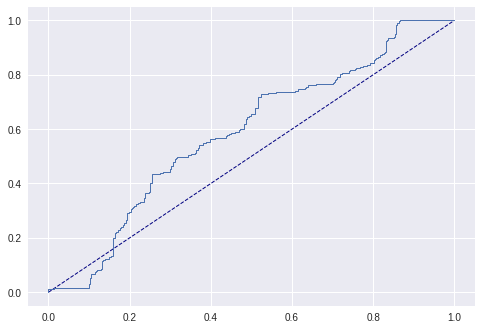

crossvalid: 0.571579, 0.554737, 0.522632, 0.650526
Test acc: 0.694000, 0.575000, 0.945000, 0.673000



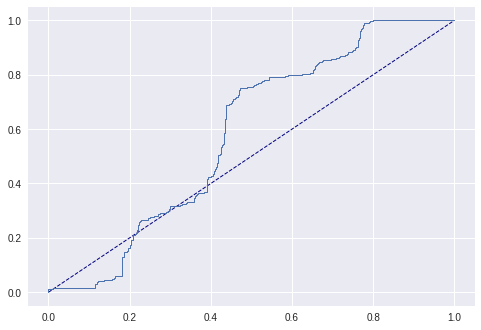

crossvalid: 0.625789, 0.534211, 0.547895, 0.588947
Test acc: 0.620000, 0.690000, 0.850000, 0.694000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

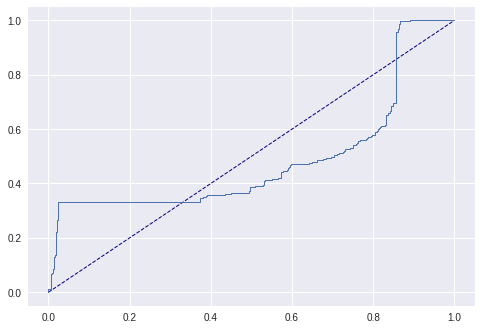

crossvalid: 0.610000, 0.654737, 0.576842, 0.594737
Test acc: 0.645000, 0.749000, 0.704000, 0.754000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


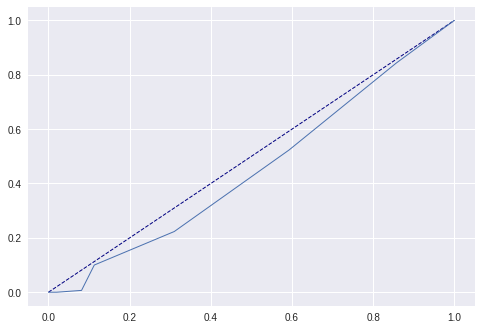

crossvalid: 0.617895, 0.796842, 0.656842, 0.553158
Test acc: 0.725000, 0.708000, 0.675000, 0.686000



In [0]:
def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)

def split_on_subject_level(list_drug, list_placebo):
    test_rate = 0.1
    dict_drug = {}
    dict_place = {}
    
    pre_aug_list_test = []
    pre_aug_label_test = []
    
    pre_aug_list_train = []
    pre_aug_label_train = []
    
    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_drug)):
        cur = random.randint(0, len(list_drug) - 1)
        if cur not in dict_drug:
            pre_aug_list_test.append(list_drug[cur])
            pre_aug_label_test.append(1)
            dict_drug[cur] = 'test'
            upperbound += 1

    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_placebo)):
        cur = random.randint(0, len(list_placebo) - 1)
        if cur not in dict_place:
            pre_aug_list_test.append(list_placebo[cur])
            pre_aug_label_test.append(0)
            dict_place[cur] = 'test'
            upperbound += 1

    for x in range(len(list_drug)):
        if x not in dict_drug:
            pre_aug_list_train.append(list_drug[x])
            pre_aug_label_train.append(1)
            
    for x in range(len(list_placebo)):
        if x not in dict_place:
            pre_aug_list_train.append(list_placebo[x])
            pre_aug_label_train.append(0)
    
    temp1 = []
    #temp2 = []
    for i in range(len(pre_aug_list_test)):
        temp1.append(pre_aug_list_test[i][:, 0, :])
        #temp2.append(pre_aug_label_test[i][:, 1, :])
        
    temp3 = []
    #temp4 = []
    for i in range(len(pre_aug_list_train)):
        temp3.append(pre_aug_list_train[i][:, 0, :])
        #temp4.append(pre_aug_label_train[i][:, 1, :])

    pre_aug_list_test = np.array(temp1)
    pre_aug_label_test = np.array(pre_aug_label_test)
    
    pre_aug_list_train = np.array(temp3)
    pre_aug_label_train = np.array(pre_aug_label_train)
    #print(pre_aug_list_train.shape)
    #print(pre_aug_label_train.shape)
    #print(pre_aug_list_test.shape)
    #print(pre_aug_label_test.shape)
    return (pre_aug_list_train, pre_aug_label_train, pre_aug_list_test, pre_aug_label_test)

[p_Xtemp, p_ytemp, p_X_test, p_y_test] = split_on_subject_level(listDrug1, listPlacebo)
######## permutation ########
if (p_Xtemp.shape[0] != p_ytemp.shape[0]):
    print("DAMN!")
permutation = np.random.permutation(p_Xtemp.shape[0])
p_Xtemp = p_Xtemp[permutation, :]
p_ytemp = p_ytemp[permutation]
######## permutation ########
def split_individual_before_aug(X, y):
    div = int(len(X) / 4)
    if len(X) != len(y):
        print('Sth wrong!!!!!!!')
    p_X1 = p_Xtemp[0 : div]
    p_y1 = p_ytemp[0 : div]
    p_X2 = p_Xtemp[div : 2 * div]
    p_y2 = p_ytemp[div : 2 * div]
    p_X3 = p_Xtemp[2 * div : 3 * div]
    p_y3 = p_ytemp[2 * div : 3 * div]
    p_X4 = p_Xtemp[3 * div :]
    p_y4 = p_ytemp[3 * div :]
    return (p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4)

p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4 = split_individual_before_aug(p_Xtemp, p_ytemp)


def aug_data(list, label, num_windows, len_windows):
    aug_list = []
    aug_label = []
    #print(list.shape[0])
    for i in range(list.shape[0]): # number of subjects
        for j in range(num_windows):
            randNum = np.random.randint(0,2700 - len_windows)
            #print(list[i].shape)
            temp = list[i][randNum : randNum + len_windows, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            #print(vec.tolist())
            aug_list.append(vec.tolist())
            aug_label.append(label[i])
        #if len(aug_label) % 100 == 0:
            #print(len(aug_label))
    aug_list = np.array(aug_list)        
    aug_label = np.array(aug_label)
    return (aug_list, aug_label)

X1, y1 = aug_data(p_X1, p_y1, 100, 1500)
X2, y2 = aug_data(p_X2, p_y2, 100, 1500)
X3, y3 = aug_data(p_X3, p_y3, 100, 1500)
X4, y4 = aug_data(p_X4, p_y4, 100, 1500)
X_test, y_test = aug_data(p_X_test, p_y_test, 100, 1500)

X1 = np.squeeze(X1, axis=(1,))
X2 = np.squeeze(X2, axis=(1,))
X3 = np.squeeze(X3, axis=(1,))
X4 = np.squeeze(X4, axis=(1,))
X_test = np.squeeze(X_test, axis=(1,))

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
'''
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
'''

# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()


## 100 X 2000

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


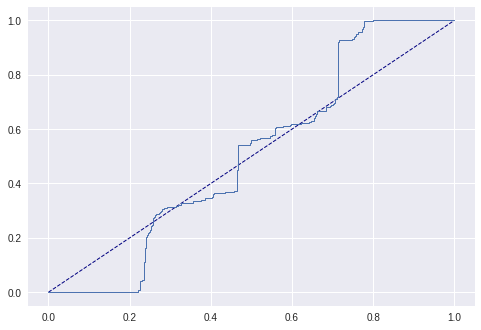

crossvalid: 0.726316, 0.580526, 0.504737, 0.421053
Test acc: 0.490000, 0.400000, 0.588000, 0.549000



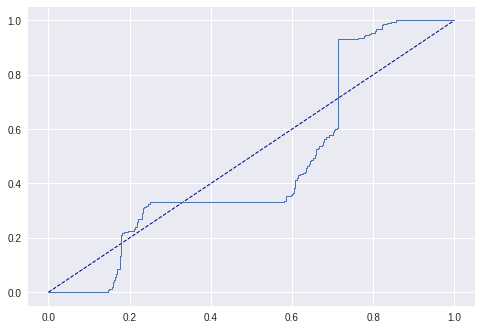

crossvalid: 0.739474, 0.594211, 0.565263, 0.405263
Test acc: 0.374000, 0.458000, 0.575000, 0.418000



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

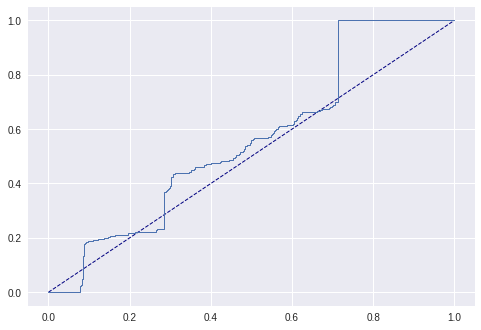

crossvalid: 0.737368, 0.607895, 0.533684, 0.400526
Test acc: 0.624000, 0.459000, 0.693000, 0.597000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


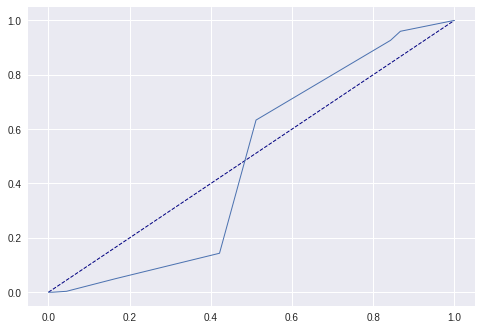

crossvalid: 0.741579, 0.475263, 0.577368, 0.754211
Test acc: 0.741000, 0.734000, 0.700000, 0.670000



In [0]:
def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    return temp

listDrug1 = cut_to_2800(listDrug1ReadDict)
listPlacebo = cut_to_2800(listPlaceboReadDict)

def split_on_subject_level(list_drug, list_placebo):
    test_rate = 0.1
    dict_drug = {}
    dict_place = {}
    
    pre_aug_list_test = []
    pre_aug_label_test = []
    
    pre_aug_list_train = []
    pre_aug_label_train = []
    
    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_drug)):
        cur = random.randint(0, len(list_drug) - 1)
        if cur not in dict_drug:
            pre_aug_list_test.append(list_drug[cur])
            pre_aug_label_test.append(1)
            dict_drug[cur] = 'test'
            upperbound += 1

    upperbound = 0
    while upperbound < math.ceil(test_rate * len(list_placebo)):
        cur = random.randint(0, len(list_placebo) - 1)
        if cur not in dict_place:
            pre_aug_list_test.append(list_placebo[cur])
            pre_aug_label_test.append(0)
            dict_place[cur] = 'test'
            upperbound += 1

    for x in range(len(list_drug)):
        if x not in dict_drug:
            pre_aug_list_train.append(list_drug[x])
            pre_aug_label_train.append(1)
            
    for x in range(len(list_placebo)):
        if x not in dict_place:
            pre_aug_list_train.append(list_placebo[x])
            pre_aug_label_train.append(0)
    
    temp1 = []
    #temp2 = []
    for i in range(len(pre_aug_list_test)):
        temp1.append(pre_aug_list_test[i][:, 0, :])
        #temp2.append(pre_aug_label_test[i][:, 1, :])
        
    temp3 = []
    #temp4 = []
    for i in range(len(pre_aug_list_train)):
        temp3.append(pre_aug_list_train[i][:, 0, :])
        #temp4.append(pre_aug_label_train[i][:, 1, :])

    pre_aug_list_test = np.array(temp1)
    pre_aug_label_test = np.array(pre_aug_label_test)
    
    pre_aug_list_train = np.array(temp3)
    pre_aug_label_train = np.array(pre_aug_label_train)
    #print(pre_aug_list_train.shape)
    #print(pre_aug_label_train.shape)
    #print(pre_aug_list_test.shape)
    #print(pre_aug_label_test.shape)
    return (pre_aug_list_train, pre_aug_label_train, pre_aug_list_test, pre_aug_label_test)

[p_Xtemp, p_ytemp, p_X_test, p_y_test] = split_on_subject_level(listDrug1, listPlacebo)
######## permutation ########
if (p_Xtemp.shape[0] != p_ytemp.shape[0]):
    print("DAMN!")
permutation = np.random.permutation(p_Xtemp.shape[0])
p_Xtemp = p_Xtemp[permutation, :]
p_ytemp = p_ytemp[permutation]
######## permutation ########
def split_individual_before_aug(X, y):
    div = int(len(X) / 4)
    if len(X) != len(y):
        print('Sth wrong!!!!!!!')
    p_X1 = p_Xtemp[0 : div]
    p_y1 = p_ytemp[0 : div]
    p_X2 = p_Xtemp[div : 2 * div]
    p_y2 = p_ytemp[div : 2 * div]
    p_X3 = p_Xtemp[2 * div : 3 * div]
    p_y3 = p_ytemp[2 * div : 3 * div]
    p_X4 = p_Xtemp[3 * div :]
    p_y4 = p_ytemp[3 * div :]
    return (p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4)

p_X1,p_y1,p_X2,p_y2,p_X3,p_y3,p_X4,p_y4 = split_individual_before_aug(p_Xtemp, p_ytemp)


def aug_data(list, label, num_windows, len_windows):
    aug_list = []
    aug_label = []
    #print(list.shape[0])
    for i in range(list.shape[0]): # number of subjects
        for j in range(num_windows):
            randNum = np.random.randint(0,2700 - len_windows)
            #print(list[i].shape)
            temp = list[i][randNum : randNum + len_windows, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            #print(vec.tolist())
            aug_list.append(vec.tolist())
            aug_label.append(label[i])
        #if len(aug_label) % 100 == 0:
            #print(len(aug_label))
    aug_list = np.array(aug_list)        
    aug_label = np.array(aug_label)
    return (aug_list, aug_label)

X1, y1 = aug_data(p_X1, p_y1, 100, 2000)
X2, y2 = aug_data(p_X2, p_y2, 100, 2000)
X3, y3 = aug_data(p_X3, p_y3, 100, 2000)
X4, y4 = aug_data(p_X4, p_y4, 100, 2000)
X_test, y_test = aug_data(p_X_test, p_y_test, 100, 2000)

X1 = np.squeeze(X1, axis=(1,))
X2 = np.squeeze(X2, axis=(1,))
X3 = np.squeeze(X3, axis=(1,))
X4 = np.squeeze(X4, axis=(1,))
X_test = np.squeeze(X_test, axis=(1,))

X_test = np.arctanh(X_test)
X1 = np.arctanh(X1)
X2 = np.arctanh(X2)
X3 = np.arctanh(X3)
X4 = np.arctanh(X4)

LinearSVC = svm.LinearSVC(penalty='l1', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
LinearSVC2 = svm.LinearSVC(penalty='l2', C=1.0, dual=False, tol=1e-5, max_iter=10000)
val_acc, test_acc = train_predict(LinearSVC2, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = LinearSVC2.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
SVC = svm.SVC()
val_acc, test_acc = train_predict(SVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = SVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()

# ==== ==== ==== ==== ==== ==== ==== ==== 
'''
NuSVC = svm.NuSVC()
val_acc, test_acc = train_predict(NuSVC, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = NuSVC.decision_function(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
'''

# ==== ==== ==== ==== ==== ==== ==== ==== 
RF = RandomForestClassifier(n_jobs=1, random_state=0)
val_acc, test_acc = train_predict(RF, X1, y1, X2, y2, X3, y3, X4, y4, X_test, y_test)
y_score = RF.predict_proba(X_test)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score[:, 1], pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()

print('crossvalid: %f, %f, %f, %f' %(val_acc[0], val_acc[1], val_acc[2], val_acc[3]))
print('Test acc: %f, %f, %f, %f' %(test_acc[0], test_acc[1], test_acc[2], test_acc[3]))
print()
